# CHARGEMENT DES LIBRAIRIES SPARK & PYTHON

In [1]:

# Spark Session
from pyspark.sql import SparkSession

# Transformations ML
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA

# Modèles supervisés
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Modèles non supervisés
from pyspark.ml.clustering import KMeans

# Pipeline & Cross-validation
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Métriques
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

# Pour créer des répertoires
import os


#Démarrage de Spark et chargement des données

In [2]:
!apt-get install openjdk-17-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 6g --executor-memory 6g pyspark-shell"


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML_Spark") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "20") \
    .getOrCreate()


In [4]:
df = spark.read.parquet("/content/drive/MyDrive/Projet_bigData/Data/consommation.parquet")

#Préparation des variables

On définit :

colonnes numériques

colonnes catégorielles

cible régression = conso_totale_mwh

cible classification = code_grand_secteur

In [5]:
# -------------------------------------------------------------
# IDENTIFICATION DES VARIABLES POUR LE ML
# -------------------------------------------------------------

# Cible régression
target_reg = "conso_totale_mwh"

# Cible classification
target_clf = "code_grand_secteur"

from pyspark.sql.types import *

numeric_types = [IntegerType, LongType, FloatType, DoubleType, ShortType, DecimalType]

numeric_cols = [c for c, t in df.dtypes if t in ["int", "bigint", "double", "float"]]
categorical_cols = [c for c, t in df.dtypes if t == "string"]

numeric_cols, categorical_cols



(['nb_sites',
  'conso_totale_mwh',
  'conso_moyenne_mwh',
  'nombre_de_mailles_secretisees',
  'part_thermosensible',
  'conso_totale_a_usages_thermosensibles_mwh',
  'conso_totale_a_usages_non_thermosensibles_mwh',
  'thermosensibilite_totale_kwh_dju',
  'conso_totale_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh',
  'conso_moyenne_a_usages_thermosensibles_mwh',
  'conso_moyenne_a_usages_non_thermosensibles_mwh',
  'thermosensibilite_moyenne_kwh_dju',
  'conso_moyenne_corrigee_de_l_alea_climatique_a_usages_thermosensibles_mwh',
  'dju_a_tr',
  'dju_a_tn',
  'nombre_d_habitants',
  'taux_de_logements_collectifs',
  'taux_de_residences_principales',
  'superficie_des_logements_30_m2',
  'superficie_des_logements_30_a_40_m2',
  'superficie_des_logements_40_a_60_m2',
  'superficie_des_logements_60_a_80_m2',
  'superficie_des_logements_80_a_100_m2',
  'superficie_des_logements_100_m2',
  'residences_principales_avant_1919',
  'residences_principales_de_1919_a_1945',
  'reside

In [6]:

# ---------------------------------------------------------
# SÉLECTION DES FEATURES COMMUNES POUR LES MODÈLES
# ---------------------------------------------------------

target_reg = "conso_totale_mwh"
target_clf = "code_grand_secteur"

# On retire les cibles et colonnes non pertinentes
feature_cols = [c for c in numeric_cols if c != target_reg]


#Encodage des catégories & Vectorisation

In [7]:
# ---------------------------------------------------------
# ENCODAGE DES COLONNES CATÉGORIELLES
# StringIndexer : transforme une catégorie → entier
# OneHotEncoder : transforme en vecteur binaire
# ---------------------------------------------------------
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

indexers = [
    StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep")
    for c in categorical_cols
]

encoders = [
    OneHotEncoder(inputCols=[c+"_idx"], outputCols=[c+"_oh"])
    for c in categorical_cols
]

# -------------------------------------------------------------
# ASSEMBLAGE DES FEATURES
# -------------------------------------------------------------

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"   # ignore les lignes contenant des valeurs nulles
)


#Régression

#Modèle 1 : Régression (RandomForest) + Pipeline + GridSearch

In [ ]:
# ---------------------------------------------------------
# RÉGRESSION AVANCÉE AVEC PIPELINE + GRIDSEARCH
# ---------------------------------------------------------
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(
    labelCol=target_reg,
    featuresCol="features",
    maxDepth=10
)

stages = indexers + encoders + [assembler, rf]

pipeline = Pipeline(stages=stages)

# Grille d'hyperparamètres
param_grid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [20, 50])
    .addGrid(rf.maxDepth, [5, 10])
    .build()
)

# Cross-validation Spark ML
evaluator = RegressionEvaluator(
    labelCol=target_reg,
    predictionCol="prediction",
    metricName="rmse"
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

# Entraînement
model_rf = cv.fit(df)

# Résultats
predictions = model_rf.transform(df)
predictions.select("conso_totale_mwh", "prediction").show(10, truncate=False)

print("RMSE =", evaluator.evaluate(predictions))


+----------------+------------------+
|conso_totale_mwh|prediction        |
+----------------+------------------+
|801.938         |619.6512989443052 |
|14497.69        |13877.075755928536|
|1264.928        |1289.862182067432 |
|3375.457        |3155.74649123847  |
|922.58          |804.8699179193561 |
|404.294         |514.1836567028347 |
|349.093         |514.1836567028347 |
|2246.463        |2272.0936178704856|
|778.208         |848.4746454138447 |
|4495.62         |4324.461063086902 |
+----------------+------------------+
only showing top 10 rows
RMSE = 10542.330915566212


In [ ]:
model_rf.save("random_forest_spark")

In [ ]:
save_path = "/content/drive/MyDrive/Projet_bigData/Modeles/RandomForest_Reg"
model_rf.save(save_path)

In [ ]:
# -------------------------------------------------------------
# RÉGRESSION : RANDOM FOREST + GRIDSEARCH
# -------------------------------------------------------------

# Modèle
rf = RandomForestRegressor(
    labelCol=target_reg,
    featuresCol="features",
    maxDepth=10
)

# Pipeline
pipeline_rf = Pipeline(stages=indexers + encoders + [assembler, rf])

# Grille d'hyperparamètres
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Évaluateur
evaluator_reg = RegressionEvaluator(
    labelCol=target_reg,
    predictionCol="prediction",
    metricName="rmse"
)

# Validation croisée
cv_rf = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_reg,
    numFolds=3
)

# Entraînement
model_rf = cv_rf.fit(df)

# Évaluation
pred_rf = model_rf.transform(df)
rmse = evaluator_reg.evaluate(pred_rf)
print("RMSE RandomForest =", rmse)


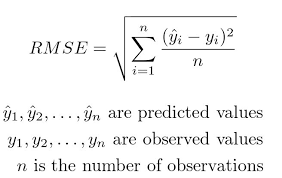

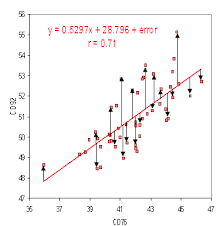

#Sauvegarde du modèle de Random Forest

In [ ]:
# -------------------------------------------------------------
# SAUVEGARDE DU MODELE SPARK ML
# -------------------------------------------------------------
save_path = "/content/drive/MyDrive/Projet_bigData/Modeles/RandomForest_Reg"

os.makedirs(save_path, exist_ok=True)

model_rf.bestModel.write().overwrite().save(save_path)

print("Modèle RandomForest enregistré dans :", save_path)

In [13]:
import os

# Dossier où enregistrer les modèles
model_dir = "/content/drive/MyDrive/Projet_bigData/Modeles"
os.makedirs(model_dir, exist_ok=True)

def save_model(model, name):
    """Sauvegarde un modèle Spark ML dans le répertoire défini."""
    path = os.path.join(model_dir, name)
    model.write().overwrite().save(path)
    print(f"Modèle sauvegardé → {path}")


#LINEAR REGRESSION

In [ ]:
# -------------------------------------------------------------
# LINEAR REGRESSION
# -------------------------------------------------------------
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(
    labelCol=target_reg,
    featuresCol="features"
)

pipeline_lr = Pipeline(stages=indexers + encoders + [assembler, lr])

param_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define evaluator_reg
evaluator_reg = RegressionEvaluator(
    labelCol=target_reg,
    predictionCol="prediction",
    metricName="rmse"
)

cv_lr = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=param_lr,
    evaluator=evaluator_reg,
    numFolds=3
)

model_lr = cv_lr.fit(df)

pred_lr = model_lr.transform(df)
print("RMSE Linear Regression =", evaluator_reg.evaluate(pred_lr))

save_model(model_lr, "regression_linear_regression")


RMSE Linear Regression = 92.5274616574565
Modèle sauvegardé → /content/drive/MyDrive/Projet_bigData/Modeles/regression_linear_regression


#DECISION TREE

In [ ]:
# -------------------------------------------------------------
# DECISION TREE REGRESSOR
# -------------------------------------------------------------
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(
    labelCol=target_reg,
    featuresCol="features"
)

pipeline_dt = Pipeline(stages=indexers + encoders + [assembler, dt])

param_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .build()

cv_dt = CrossValidator(
    estimator=pipeline_dt,
    estimatorParamMaps=param_dt,
    evaluator=evaluator_reg,
    numFolds=3
)

model_dt = cv_dt.fit(df)

pred_dt = model_dt.transform(df)
print("RMSE Decision Tree =", evaluator_reg.evaluate(pred_dt))

save_model(model_dt, "regression_decision_tree")


RMSE Decision Tree = 3899.3801604141045
Modèle sauvegardé → /content/drive/MyDrive/Projet_bigData/Modeles/regression_decision_tree


#GBT (Gradient Boosted Trees)

In [ ]:
# -------------------------------------------------------------
# GBT REGRESSOR
# -------------------------------------------------------------
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    labelCol=target_reg,
    featuresCol="features",
    maxIter=30
)

pipeline_gbt = Pipeline(stages=indexers + encoders + [assembler, gbt])

param_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .build()

cv_gbt = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=param_gbt,
    evaluator=evaluator_reg,
    numFolds=3
)

model_gbt = cv_gbt.fit(df)

pred_gbt = model_gbt.transform(df)
print("RMSE GBT =", evaluator_reg.evaluate(pred_gbt))

save_model(model_gbt, "regression_gbt")


RMSE GBT = 1460.936383368422
Modèle sauvegardé → /content/drive/MyDrive/Projet_bigData/Modeles/regression_gbt


# CLASSIFICATION

#Modèle 2 : Classification (RandomForestClassifier)

In [8]:
# -------------------------------------------------------------
# CLASSIFICATION : RANDOM FOREST
# -------------------------------------------------------------

rf_clf = RandomForestClassifier(
    labelCol=target_clf + "_idx",
    featuresCol="features"
)

pipeline_clf = Pipeline(stages=indexers + encoders + [assembler, rf_clf])

model_clf = pipeline_clf.fit(df)

pred_clf = model_clf.transform(df)

# Évaluateur F1-score
evaluator_clf = MulticlassClassificationEvaluator(
    labelCol=target_clf + "_idx",
    predictionCol="prediction",
    metricName="f1"
)

f1 = evaluator_clf.evaluate(pred_clf)
print("F1-score Classification =", f1)


F1-score Classification = 1.0


#Sauvegarde modèle classification

In [10]:
save_path = "/content/drive/MyDrive/Projet_bigData/Modeles/RandomForest_Clf"

os.makedirs(save_path, exist_ok=True)

model_clf.write().overwrite().save(save_path)

print("Modèle Classification sauvegardé !")


Modèle Classification sauvegardé !


#LOGISTIC REGRESSION

In [12]:
# -------------------------------------------------------------
# LOGISTIC REGRESSION CLASSIFIER
# -------------------------------------------------------------
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr_c = LogisticRegression(
    labelCol=target_clf + "_idx",
    featuresCol="features"
)

pipeline_lr_c = Pipeline(stages=indexers + encoders + [assembler, lr_c])

param_lr_c = ParamGridBuilder() \
    .addGrid(lr_c.regParam, [0.0, 0.1, 0.5]) \
    .addGrid(lr_c.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator_clf = MulticlassClassificationEvaluator(
    labelCol=target_clf + "_idx",
    predictionCol="prediction",
    metricName="f1"
)

cv_lr_c = CrossValidator(
    estimator=pipeline_lr_c,
    estimatorParamMaps=param_lr_c,
    evaluator=evaluator_clf,
    numFolds=3
)

model_lr_c = cv_lr_c.fit(df)

pred_lr_c = model_lr_c.transform(df)
print("F1 Logistic Regression =", evaluator_clf.evaluate(pred_lr_c))




F1 Logistic Regression = 1.0


NameError: name 'save_model' is not defined

In [14]:
save_model(model_lr_c, "classification_logistic_regression")

Modèle sauvegardé → /content/drive/MyDrive/Projet_bigData/Modeles/classification_logistic_regression


#DECISION TREE

In [16]:
# -------------------------------------------------------------
# DECISION TREE CLASSIFIER
# -------------------------------------------------------------
from pyspark.ml.classification import DecisionTreeClassifier

dt_c = DecisionTreeClassifier(
    labelCol=target_clf + "_idx",
    featuresCol="features"
)

pipeline_dt_c = Pipeline(stages=indexers + encoders + [assembler, dt_c])

param_dt_c = ParamGridBuilder() \
    .addGrid(dt_c.maxDepth, [5, 10, 15]) \
    .build()

cv_dt_c = CrossValidator(
    estimator=pipeline_dt_c,
    estimatorParamMaps=param_dt_c,
    evaluator=evaluator_clf,
    numFolds=3
)

model_dt_c = cv_dt_c.fit(df)

pred_dt_c = model_dt_c.transform(df)
print("F1 Decision Tree =", evaluator_clf.evaluate(pred_dt_c))

save_model(model_dt_c, "classification_decision_tree")


F1 Decision Tree = 1.0
Modèle sauvegardé → /content/drive/MyDrive/Projet_bigData/Modeles/classification_decision_tree


# RANDOM FOREST CLASSIFIER

In [18]:
# -------------------------------------------------------------
# RANDOM FOREST CLASSIFIER
# -------------------------------------------------------------
from pyspark.ml.classification import RandomForestClassifier

rf_c = RandomForestClassifier(
    labelCol=target_clf + "_idx",
    featuresCol="features"
)

pipeline_rf_c = Pipeline(stages=indexers + encoders + [assembler, rf_c])

param_rf_c = ParamGridBuilder() \
    .addGrid(rf_c.numTrees, [20, 50]) \
    .addGrid(rf_c.maxDepth, [5, 10]) \
    .build()

cv_rf_c = CrossValidator(
    estimator=pipeline_rf_c,
    estimatorParamMaps=param_rf_c,
    evaluator=evaluator_clf,
    numFolds=3
)

model_rf_c = cv_rf_c.fit(df)

pred_rf_c = model_rf_c.transform(df)
print("F1 Random Forest =", evaluator_clf.evaluate(pred_rf_c))

save_model(model_rf_c, "classification_random_forest")


F1 Random Forest = 1.0
Modèle sauvegardé → /content/drive/MyDrive/Projet_bigData/Modeles/classification_random_forest


#Clustering KMeans (non supervisé)

In [19]:
from pyspark.ml.evaluation import ClusteringEvaluator



# featuresCol → colonnes utilisées pour le clustering (après assemblage)
# predictionCol → colonne contenant le numéro du cluster attribué
kmeans = KMeans(
    k=4,
    featuresCol="features",
    predictionCol="cluster",
    seed=42  # graine pour la reproductibilité
)

# Construction du pipeline complet
# Étapes :
#   1. Indexation des variables catégorielles
#   2. One-Hot Encoding
#   3. Assemblage des features numériques + encodées
#   4. Modèle de clustering K-Means
pipeline_kmeans = Pipeline(stages=indexers + encoders + [assembler, kmeans])

# Entraînement du modèle sur les données
model_kmeans = pipeline_kmeans.fit(df)

# Application du modèle sur le dataset pour obtenir les clusters
clusters = model_kmeans.transform(df)

# Affichage des premiers clusters prédits
clusters.select("cluster").show(20)

# -------------------------------------------------------------
# ÉVALUATION DU CLUSTERING
# -------------------------------------------------------------


evaluator = ClusteringEvaluator(
    featuresCol="features",
    predictionCol="cluster",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

# Calcul du score Silhouette
silhouette_score = evaluator.evaluate(clusters)

# Affichage du résultat
print("Silhouette Score du modèle K-Means :", silhouette_score)

+-------+
|cluster|
+-------+
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
|      0|
+-------+
only showing top 20 rows
Silhouette Score du modèle K-Means : 0.9900755890017877


#PCA (réduction de dimension)

In [23]:
# -------------------------------------------------------------
# PCA POUR RÉDUCTION DE DIMENSION
# -------------------------------------------------------------

# StandardScaler : normalise les features (moyenne = 0, variance = 1)
# indispensable car le PCA est sensible aux différences d’échelle
scaler = StandardScaler(
    inputCol="features",        # colonne d'entrée contenant le vecteur de features
    outputCol="scaledFeatures"  # colonne de sortie normalisée
)



pca = PCA(
    k=2,                         # nombre de composantes principales à conserver
    inputCol="scaledFeatures",   # données normalisées en entrée
    outputCol="pcaFeatures"      # colonne résultat contenant les axes PCA
)

# Pipeline complet :
# encodage → assemblage → normalisation → PCA
pipeline_pca = Pipeline(
    stages=indexers              # indexation des variables catégorielles
          + encoders             # encodage One-Hot
          + [assembler]          # assemblage dans un vecteur "features"
          + [scaler, pca]        # normalisation puis PCA
)

# Entraînement du pipeline PCA sur l’ensemble du dataset
model_pca = pipeline_pca.fit(df)

# Transformation du dataset : création de la colonne pcaFeatures
df_pca = model_pca.transform(df)

# Affichage des résultats PCA (les 2 composantes principales)
df_pca.select("pcaFeatures").show(5, truncate=False)


+----------------------------------------+
|pcaFeatures                             |
+----------------------------------------+
|[0.83356068294205,-10.229639755213642]  |
|[-1.0228432284622617,-7.572346034195326]|
|[0.6451971480560973,-8.955527969731376] |
|[0.6097687898533364,-9.916595445693694] |
|[0.8254026064264587,-10.10647945477744] |
+----------------------------------------+
only showing top 5 rows


#K-Means + PCA (Clustering non supervisé)

In [25]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Définition du modèle de clustering
# → On utilise les 2 composantes PCA comme features d'entrée
kmeans = KMeans(
    featuresCol="pcaFeatures",   # colonne contenant les axes PCA
    predictionCol="cluster",     # colonne de sortie contenant le cluster assigné
    k=5,                         # nombre de clusters à rechercher
    seed=42                      # graine pour la reproductibilité
)

# Entraînement du modèle KMeans
kmeans_model = kmeans.fit(df_pca)

# Application du modèle sur les données
df_clusters = kmeans_model.transform(df_pca)

# Affichage des premiers résultats
df_clusters.select("pcaFeatures", "cluster").show(10, truncate=False)

# Évaluation du clustering avec le Silhouette Score
evaluator_kmeans = ClusteringEvaluator(
    featuresCol="pcaFeatures",   # évalue la qualité du clustering sur l’espace PCA
    predictionCol="cluster",     # The prediction column, output of the KMeans model
    metricName="silhouette",     # métrique Silhouette
    distanceMeasure="squaredEuclidean"
)

sil_score = evaluator_kmeans.evaluate(df_clusters)
print("Silhouette Score =", sil_score)


+----------------------------------------+-------+
|pcaFeatures                             |cluster|
+----------------------------------------+-------+
|[0.83356068294205,-10.229639755213642]  |0      |
|[-1.0228432284622617,-7.572346034195326]|4      |
|[0.6451971480560973,-8.955527969731376] |0      |
|[0.6097687898533364,-9.916595445693694] |0      |
|[0.8254026064264587,-10.10647945477744] |0      |
|[0.5744146552051081,-5.67360776232903]  |4      |
|[0.8166083837781243,-9.425631678972048] |0      |
|[0.3312905765278011,-6.606421222601355] |4      |
|[0.4089364664335445,-4.821342745176652] |4      |
|[0.4561953474608089,-10.577815944691537]|0      |
+----------------------------------------+-------+
only showing top 10 rows
Silhouette Score = 0.6512407261291577


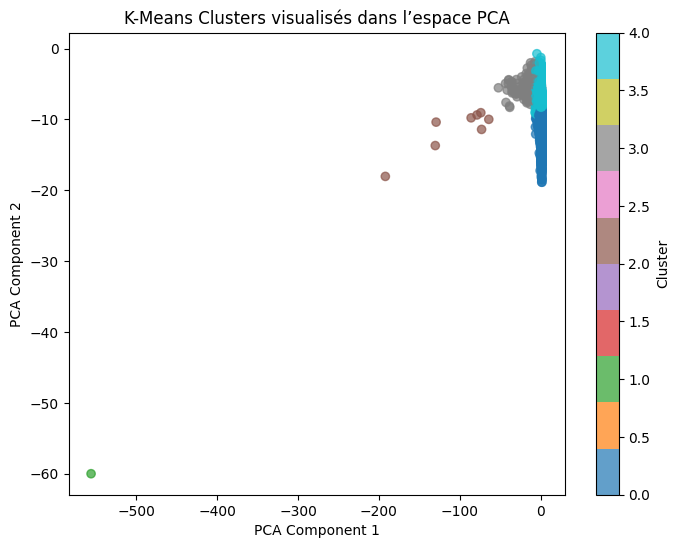

In [29]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
df_plot = df_clusters.select(
    vector_to_array(col("pcaFeatures")).getItem(0).alias("x"),
    vector_to_array(col("pcaFeatures")).getItem(1).alias("y"),
    col("cluster")
)
pdf = df_plot.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    pdf["x"],
    pdf["y"],
    c=pdf["cluster"],
    cmap="tab10",
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters visualisés dans l’espace PCA")

plt.colorbar(scatter, label="Cluster")
plt.show()


In [36]:
import plotly.express as px

fig = px.scatter(
    pdf,
    x="x",
    y="y",
    color="cluster",
    title="Clusters K-Means (PCA 2D)",
    opacity=0.7
)
fig.show()


#PCA avec contours de clusters

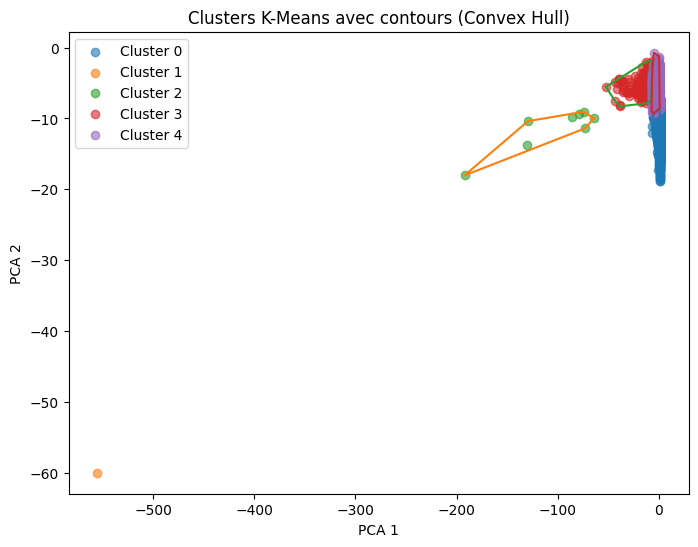

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

plt.figure(figsize=(8,6))

for cluster_id in sorted(pdf["cluster"].unique()):
    cluster_points = pdf[pdf["cluster"] == cluster_id][["x","y"]].values
    plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f"Cluster {cluster_id}", alpha=0.6)

    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        hull_points = cluster_points[hull.vertices]
        plt.plot(
            np.append(hull_points[:,0], hull_points[0,0]),
            np.append(hull_points[:,1], hull_points[0,1])
        )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters K-Means avec contours (Convex Hull)")
plt.legend()
plt.show()


#Densité des clusters (KDE)

/tmp/ipython-input-3640359648.py:4: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


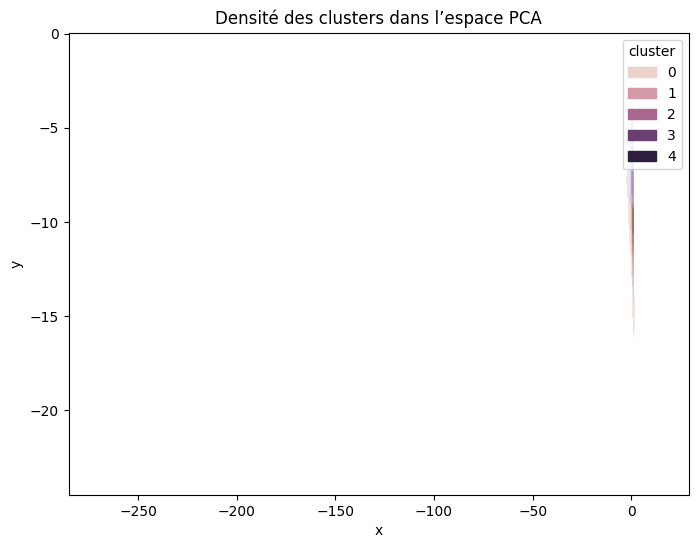

In [32]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.kdeplot(
    data=pdf,
    x="x",
    y="y",
    hue="cluster",
    fill=True,
    alpha=0.4
)
plt.title("Densité des clusters dans l’espace PCA")
plt.show()


#3️Boxplot par cluster (interprétation quantitative)

Montre la dispersion des clusters sur chaque axe PCA.

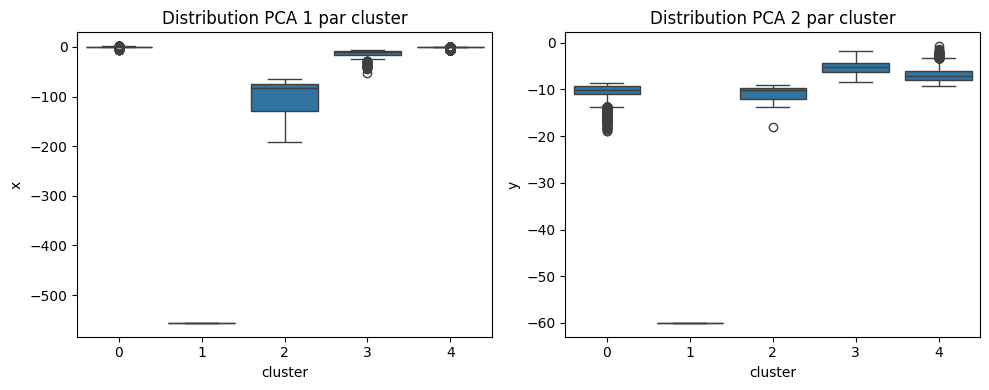

In [33]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.boxplot(data=pdf, x="cluster", y="x")
plt.title("Distribution PCA 1 par cluster")

plt.subplot(1,2,2)
sns.boxplot(data=pdf, x="cluster", y="y")
plt.title("Distribution PCA 2 par cluster")

plt.tight_layout()
plt.show()


#Taille des clusters (bar chart)

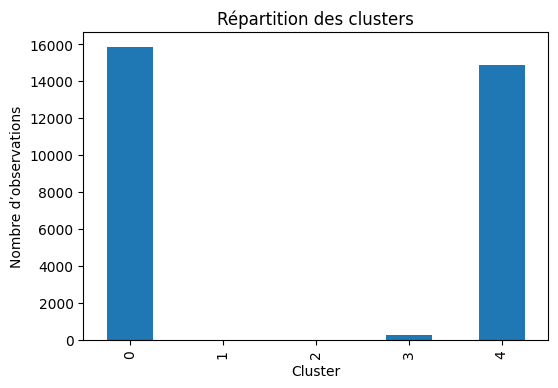

In [34]:
cluster_sizes = pdf["cluster"].value_counts().sort_index()

plt.figure(figsize=(6,4))
cluster_sizes.plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Nombre d’observations")
plt.title("Répartition des clusters")
plt.show()


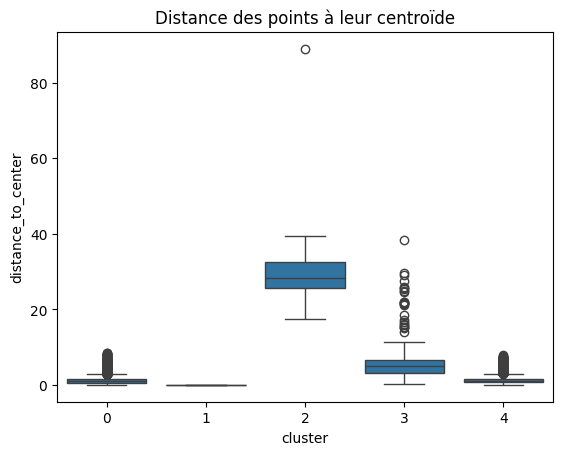

In [38]:
from scipy.spatial.distance import cdist

centers = kmeans_model.clusterCenters()
distances = []

for i, row in pdf.iterrows():
    # Cast the 'cluster' value to an integer before using it as an index
    d = cdist([[row["x"], row["y"]]], centers)[0][int(row["cluster"])]
    distances.append(d)

pdf["distance_to_center"] = distances

sns.boxplot(data=pdf, x="cluster", y="distance_to_center")
plt.title("Distance des points à leur centroïde")
plt.show()
